# Predict wine taste preferences with logistic regression
15-Sep-2016

The goal of this assignment is to understand the relationships between the characteristics of the wine and predict the quality of the wine based on those characteristics.

A set of logistic regression models are going to be developed to solve the problem. The approaches that are going to be implemented are : forward stepwise selection  ,ridge regularization , and lasso regularization.


The libraries that are going to be used are "glmnet" in order to implement the rigde and lasso regularizations , the "ROCR" in order to make the ROC curve ,and the "leaps" library in order to apply the forward stepwise selection.

In [516]:
# Set working directory
setwd("C:\\Users\\vasil\\Desktop\\Assigment")
# Load the libraries
library(glmnet)
library(ROCR)
library(leaps)

In [517]:
# Data engineering
testing<-read.csv("Wine_testing.csv")
training <-read.csv("Wine_training.csv")
data <-read.csv("wine.csv")

## 1.Model development
### 1.1Stepwise forward selection
This approach has various advantages and disadvantages. 
Some of the benefits of this approach are that models are easy to inteprete and easy to compute.
But it is possible to miss the "optimal" model due to drop and add variables one at a time .
Also this method can overestimate the significance of the results, so we should be conservative 
when we evaluate the p-values


There will be developed two models ,for the first model is going to be used the glm() function (steps based on AIC) while for the second model is going to be used the regsubsets() function (steps based on BIC and R^2) from the "leaps" library.

In [518]:
fullmodel <- glm(quality ~.,family=binomial(link='logit'),data=training)
nothing <- glm(quality ~ 1,family = binomial,data = training)
forwards <- step(nothing,scope=list(lower=formula(nothing),upper=formula(fullmodel)),
                direction="forward")

Start:  AIC=4195.98
quality ~ 1

                       Df Deviance    AIC
+ alcohol               1   3562.4 3566.4
+ density               1   3897.6 3901.6
+ volatile.acidity      1   4016.1 4020.1
+ chlorides             1   4059.7 4063.7
+ total.sulfur.dioxide  1   4086.5 4090.5
+ residual.sugar        1   4153.2 4157.2
+ pH                    1   4155.3 4159.3
+ fixed.acidity         1   4159.6 4163.6
+ sulphates             1   4180.8 4184.8
<none>                      4194.0 4196.0
+ free.sulfur.dioxide   1   4193.7 4197.7
+ citric.acid           1   4194.0 4198.0

Step:  AIC=3566.45
quality ~ alcohol

                       Df Deviance    AIC
+ volatile.acidity      1   3336.1 3342.1
+ free.sulfur.dioxide   1   3518.2 3524.2
+ residual.sugar        1   3537.5 3543.5
+ sulphates             1   3543.1 3549.1
+ fixed.acidity         1   3546.6 3552.6
+ pH                    1   3547.8 3553.8
+ density               1   3554.1 3560.1
+ chlorides             1   3554.7 3560.7
+ ci

In [519]:
regfit.fwd <- regsubsets(formula(fullmodel), data = training, nvmax = 10, method = "forward")
reg.summary.fwd <- summary(regfit.fwd)
reg.summary.fwd 


Subset selection object
Call: regsubsets.formula(formula(fullmodel), data = training, nvmax = 10, 
    method = "forward")
11 Variables  (and intercept)
                     Forced in Forced out
fixed.acidity            FALSE      FALSE
volatile.acidity         FALSE      FALSE
citric.acid              FALSE      FALSE
residual.sugar           FALSE      FALSE
chlorides                FALSE      FALSE
free.sulfur.dioxide      FALSE      FALSE
total.sulfur.dioxide     FALSE      FALSE
density                  FALSE      FALSE
pH                       FALSE      FALSE
sulphates                FALSE      FALSE
alcohol                  FALSE      FALSE
1 subsets of each size up to 10
Selection Algorithm: forward
          fixed.acidity volatile.acidity citric.acid residual.sugar chlorides
1  ( 1 )  " "           " "              " "         " "            " "      
2  ( 1 )  " "           "*"              " "         " "            " "      
3  ( 1 )  " "           "*"              " "    

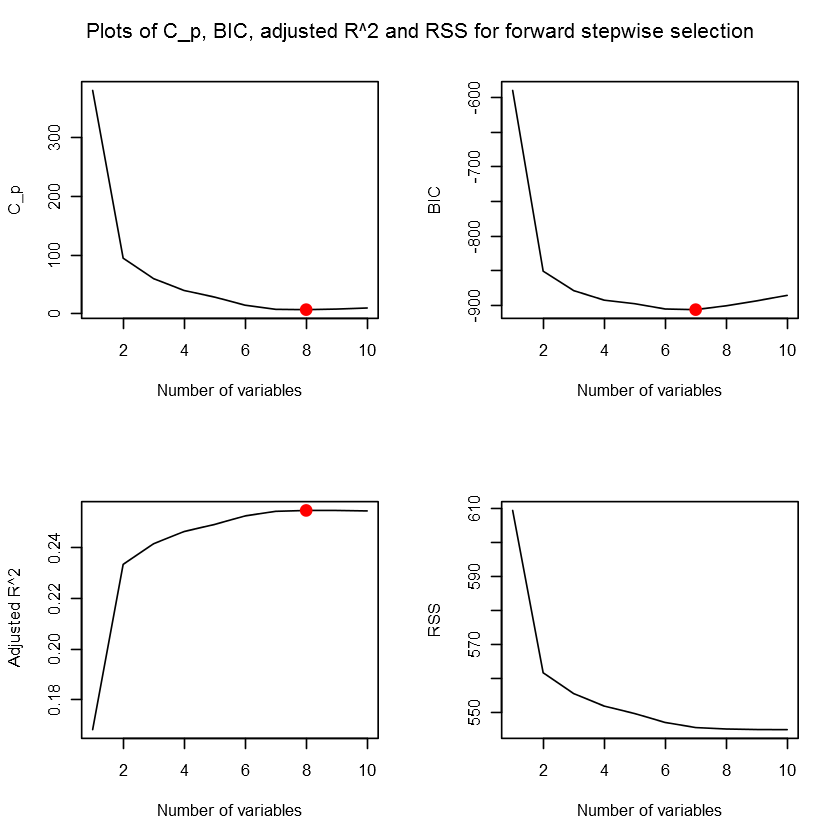

In [520]:
par(mfrow = c(2, 2))
plot(reg.summary.fwd$cp, xlab = "Number of variables", ylab = "C_p", type = "l")
points(which.min(reg.summary.fwd$cp), reg.summary.fwd$cp[which.min(reg.summary.fwd$cp)], col = "red", cex = 2, pch = 20)
plot(reg.summary.fwd$bic, xlab = "Number of variables", ylab = "BIC", type = "l")
points(which.min(reg.summary.fwd$bic), reg.summary.fwd$bic[which.min(reg.summary.fwd$bic)], col = "red", cex = 2, pch = 20)
plot(reg.summary.fwd$adjr2, xlab = "Number of variables", ylab = "Adjusted R^2", type = "l")
points(which.max(reg.summary.fwd$adjr2), reg.summary.fwd$adjr2[which.max(reg.summary.fwd$adjr2)], col = "red", cex = 2, pch = 20)
plot(reg.summary.fwd$rss, xlab = "Number of variables", ylab = "RSS", type = "l")
mtext("Plots of C_p, BIC, adjusted R^2 and RSS for forward stepwise selection", side = 3, line = -2, outer = TRUE)


As we can see below , both models use the same variables (8) but there is a difference on the slope of the variables. This is due to the way that each model is calculated.

In [522]:
coef(regfit.fwd, 8)
coef(forwards)

(Intercept)     volatile.acidity       residual.sugar 
        2.588255e+01        -1.138075e+00         2.005106e-02 
 free.sulfur.dioxide total.sulfur.dioxide              density 
        1.883050e-03        -3.983241e-04        -2.665402e+01 
                  pH            sulphates              alcohol 
        2.416200e-01         2.891461e-01         1.459841e-01

(Intercept)             alcohol    volatile.acidity      residual.sugar 
       1.595063e+02        9.116745e-01       -6.646741e+00        1.222942e-01 
      fixed.acidity           sulphates free.sulfur.dioxide                  pH 
      -5.689444e-02        1.919119e+00        8.665735e-03        1.141205e+00 
            density 
      -1.726497e+02

### 1.2.Ringe regularization
 The ringe regularization approach is going to be developed using the cv.glmnet() function , in order to develop the ringe regularization model the "alpha" parameter needs to be 0 .
 The cv.glmnet() function is used , instead of glmnet(), because we need to use the cross validation approach to take the single best model.
 
The Ringe regularization is preferred over Lasso because it can deal with situations when the number of features is greater than the number of samples where Lasso behaves erratically. 

In [529]:
x <- data.matrix(training[,-12])
x_test<-data.matrix(testing[,-12])

In [536]:
cv_ringe <- cv.glmnet(x, training$quality, family='binomial', type.measure = "class",alpha = 0)


### 1.3.Lasso regularization
 The ringe regularization approach is going to be developed using the cv.glmnet() function , in order to develop the lasso regularization model the "alpha" parameter needs to be 1 .
As the previous approach , we use the cv.glmnet() function instead of the simple glmnet() in order to have a better model.

Lasso is preferred over ridge regularization when the solution is believed to have sparse features because L1 regularization promotes sparsity  while L2 regularization does not.

In [537]:
cv_lasso <- cv.glmnet(x, training$quality, family='binomial', type.measure = "class",alpha = 1)


## 2. Model assessment



In order to find the best model , we will use k-fold cross validation. 

In [523]:
#Randomly shuffle the data
data<-data[sample(nrow(data)),]

#Create 10 equally size folds
folds <- cut(seq(1,nrow(data)),breaks=10,labels=FALSE)
x<-seq(0, 0, length.out = 11)
maxX<- x[1]

#Perform 10 fold cross validation
for(i in 1:10){
    #Segement your data by fold using the which() function 
    testIndexes <- which(folds==i,arr.ind=TRUE)
    testData <- data[testIndexes, ]
    trainData <- data[-testIndexes, ]
    mod_fit_for <- glm(formula(forwards), data=trainData, family="binomial")   
    
    prob_for <- predict(mod_fit_for, newdata=testData[,-12], type="response")
    pred_for <- prediction(prob_for, testData$quality)
    auc_for <- performance(pred_for, measure = "auc")
    auc_for <- auc_for@y.values[[1]]
    x[i]<-auc_for
    if(x[i] >= maxX){
        ## do comparison with current target
      maxX <- x[i]  ## if element i is smaller than target, update target
    }    
}
print(maxX)

[1] 0.838002


As we can see, the auc of the best model is above 0.8 which indicates that the model is good at discriminating between the two classes of the target variable.


We need to find the best lambdas for each model in order to make the most accurate prediction.

In [538]:
best_lambda_lasso <- cv_lasso$lambda.min
best_lambda_ringe <- cv_ringe$lambda.min
best_lambda_lasso
best_lambda_ringe

[1] 0.003897106

[1] 0.02128708

After having found the lambdas we are able to proceed to the prediction and evaluation of the model .

In [539]:
prob_lasso <-predict(cv_lasso, newx = x_test, type = "response", s = best_lambda_lasso)
pred_lasso <- prediction(prob_lasso, testing$quality)

auc_lasso <- performance(pred_lasso, measure = "auc")
auc_lasso <- auc_lasso@y.values[[1]]
auc_lasso

prob_ringe <-predict(cv_ringe, newx = x_test, type = "response", s = best_lambda_ringe)
pred_ringe <- prediction(prob_ringe, testing$quality)


auc_ringe <- performance(pred_ringe, measure = "auc")
auc_ringe<- auc_ringe@y.values[[1]]
auc_ringe

[1] 0.7578828

[1] 0.7629913

As we can see from the results above , both models tend to have approximately the same AUC which in not bad but also not quite good. That metric ranges from 0.5 to 1, the values above 0.8 indicate that the model is good at discriminating between the two classes of the target variable. Our AUCs are approximately 0.76 , for all the models.